# Question 4: Clustering – Movies Clustering (1.0 mark)

Build a clustering model to cluster the movies in tmdb_5000_movies.csv dataset.
Explain the main characteristics of each cluster. Use WordCloud to visualize each cluster.
(Hint: Use some features such as 'title', 'tagline', 'overview', 'popularity'…)

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline, Transformer

from bs4 import BeautifulSoup

from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [3]:
spark = SparkSession.builder.appName('kmeans_tmdb_movies').getOrCreate()
spark

# Clean and Prepare the Data

In [4]:
# Loads data.
movies = spark.read.csv("tmdb_5000_movies.csv", escape='"',header=True, inferSchema=True)

In [5]:
movies.show(2, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 budget               | 237000000                                                                                                                                                                                                              

In [6]:
movies.printSchema()

root
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: string (nullable = true)



In [7]:
#3. Kiểm tra dữ liệu NaN, null
movies.select([count(when(isnan(c), c)).alias(c) for c in movies.columns]).toPandas().T

,0
budget,0
genres,0
homepage,0
id,0
keywords,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0


In [8]:
movies.select([count(when(col(c).isNull(), c)).alias(c) for c in movies.columns]).toPandas().T

,0
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,3
production_companies,3


In [9]:
movies.count()

4806

In [10]:
# Selecting relevant features
selected_features = ['id', 'genres','title', 'keywords', 'overview']
df = movies.select(selected_features)

In [11]:
df.show(2, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id       | 19995                                                                                                                                                                                                                                          

### Xử lý cột genres

In [12]:
# Define schemas
json_schema = ArrayType(StructType([
  StructField("id", StringType(), True),
  StructField("name", StringType(), True)
]))

schema = ArrayType(StringType())

In [13]:
genres_df = df \
.withColumn('split', explode(from_json(col('genres'), schema))) \
.withColumn('genre_json', explode(from_json('genres', json_schema))) \
.withColumn('genres_name', col('genre_json.name')) \
.select('id','genres_name') \
.distinct() \
.orderBy('title','genres_name', ascending=True) \
.groupBy('id').agg(collect_list(col('genres_name')).alias('genres_in_array')) \
.withColumn("genres_in_string", concat_ws(", ", col("genres_in_array"))) \
.select('id','genres_in_string')

genres_df.show(5, truncate=False)

+------+-----------------------------------------------------+
|id    |genres_in_string                                     |
+------+-----------------------------------------------------+
|100   |Comedy, Crime                                        |
|10003 |Action, Adventure, Romance, Science Fiction, Thriller|
|100042|Comedy                                               |
|10008 |Horror, Thriller                                     |
|10012 |Comedy, Horror                                       |
+------+-----------------------------------------------------+
only showing top 5 rows



In [14]:
df2 = genres_df \
.join(df, on='id', how='left_outer') 

df2.show(5, truncate=False)

+------+-----------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------

In [15]:
keywords_df = df \
.withColumn('split', explode(from_json(col('keywords'), schema))) \
.withColumn('genre_json', explode(from_json('keywords', json_schema))) \
.withColumn('keywords_name', col('genre_json.name')) \
.select('id','keywords_name') \
.distinct() \
.orderBy('title','keywords_name', ascending=True) \
.groupBy('id').agg(collect_list(col('keywords_name')).alias('keywords_in_array')) \
.withColumn("keywords_in_string", concat_ws(", ", col("keywords_in_array"))) \
.select('id','keywords_in_string')

keywords_df.show(5, truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id    |keywords_in_string                                                                                                                                                                     |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|100   |alcohol, ambush, anger, antique, cardsharp, carjacking, cockney accent, cocktail, hatchet, high stakes, joint, machismo, marijuana, piano, pot smoking, rifle, shotgun, strip show, tea|
|10003 |berlin, gas, master thief, russia, the saint                                                                                                                                           |
|100042|buddy comedy, friendship, r

In [16]:
df2 = keywords_df \
.join(df2, on='id', how='left_outer') 

df2.show(5, truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
#3. Kiểm tra dữ liệu NaN, null
df2.select([count(when(isnan(c), c)).alias(c) for c in df2.columns]).toPandas().T

,0
id,0
keywords_in_string,0
genres_in_string,0
genres,0
title,0
keywords,0
overview,0


In [18]:
df2.select([count(when(col(c).isNull(), c)).alias(c) for c in df2.columns]).toPandas().T

,0
id,0
keywords_in_string,0
genres_in_string,2
genres,2
title,5
keywords,2
overview,4


In [19]:
df2.count()

4391

In [20]:
df2 = df2.dropna()

In [21]:
df2.select([count(when(col(c).isNull(), c)).alias(c) for c in df2.columns]).toPandas().T

,0
id,0
keywords_in_string,0
genres_in_string,0
genres,0
title,0
keywords,0
overview,0


In [22]:
df2 = df2.withColumn("Document", concat_ws(" ", "genres_in_string", "keywords_in_string","title", "overview"))

In [23]:
#4. Kiểm tra dữ liệu trùng. 
num_rows = df2.count()
num_dist_rows = df2.distinct().count()
dup_rows = num_rows - num_dist_rows

In [24]:
display(num_rows, num_dist_rows, dup_rows)

4384

4384

0

In [25]:
df2 = df2.withColumn('Document', lower(col('Document'))) 

In [26]:
df2.count()

4384

In [27]:
df2.show(2, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                 | 100                                                                                                                                                                                                                                                                                                         

## Feature Transformations

In [28]:
class BsTextExtractor(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(BsTextExtractor, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):

        def f(s):
            cleaned_post = BeautifulSoup(s).text
            return cleaned_post

        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

In [29]:
text_extractor = BsTextExtractor(inputCol="Document", outputCol="cleaned_Doc") #3
tokenizer = RegexTokenizer(inputCol="cleaned_Doc", outputCol="token_text", pattern="\\W") #4
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens') #5
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec') #6
idf = IDF(inputCol="c_vec", outputCol="tf_idf") #7

In [30]:
clean_up = VectorAssembler(inputCols=['tf_idf'],
                           outputCol='features') # 8

## Pipeline

In [31]:
data_prep_pipe = Pipeline(stages=[text_extractor,
                                  tokenizer,
                                  stopremove,
                                  count_vec,
                                  idf,
                                  clean_up])

In [32]:
df2.show(2, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                 | 100                                                                                                                                                                                                                                                                                                         

In [33]:
cleaner = data_prep_pipe.fit(df2)

In [34]:
final_data = cleaner.transform(df2)

In [35]:
final_data.count()

4384

In [36]:
final_data.show(2, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Train the Model and Evaluate

### Seleck k if we know k between 2 - 10

In [37]:
# Trains a k-means model.
k_list = []
wssse_list = []
wssse_str = ""
silhouette_list = []
sil_str = ""



for k in range(2,11):
    k_list.append(k)
    
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)
    wssse_str = wssse_str + "With k =" + str(k) + "- WSSSE = " + str(wssse) + "\n"
    
    # silhoutte
    predictions = model.transform(final_data)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

In [38]:
print(wssse_str)

With k =2- WSSSE = 6667239.564762354
With k =3- WSSSE = 6658025.897861576
With k =4- WSSSE = 6669378.514505218
With k =5- WSSSE = 6664564.74708118
With k =6- WSSSE = 6657642.469712609
With k =7- WSSSE = 6647707.809332341
With k =8- WSSSE = 6647575.038950125
With k =9- WSSSE = 6645860.687504082
With k =10- WSSSE = 6643269.075558621



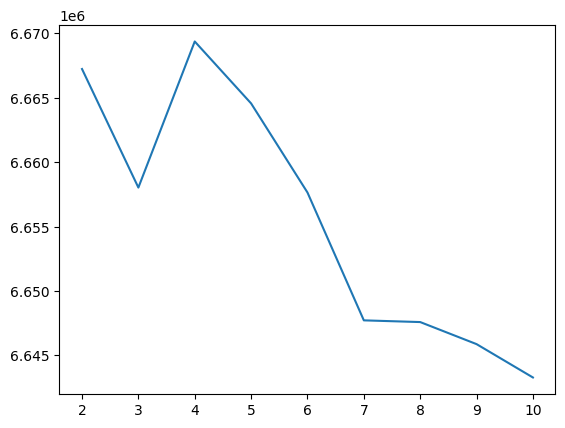

In [39]:
plt.plot(k_list, wssse_list)
plt.show()

In [40]:
print(sil_str)

With k =2- Silhouette = 0.063304319265302
With k =3- Silhouette = 0.06528376531967649
With k =4- Silhouette = 0.12078475004865206
With k =5- Silhouette = 0.07070411320579344
With k =6- Silhouette = 0.07205230729022218
With k =7- Silhouette = -0.00041312726615491154
With k =8- Silhouette = 0.004439889715793977
With k =9- Silhouette = -0.14448732637509903
With k =10- Silhouette = -0.14435593616950188



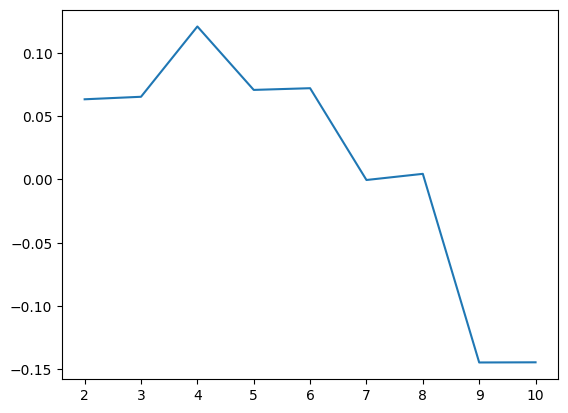

In [41]:
plt.plot(k_list, silhouette_list)
plt.show()

#### Select k = 5

In [42]:
# Trains a k-means model.
kmeans = KMeans(featuresCol = 'features', 
                predictionCol  = 'prediction', 
                maxIter = 20,
                seed = 42,
                k = 5,
                distanceMeasure = 'cosine') 
model = kmeans.fit(final_data)

In [43]:
predictions = model.transform(final_data)

In [44]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.09265589 0.03223807 0.03944854 ... 0.         0.         0.        ]
[0.1130822  0.09487095 0.06550779 ... 0.         0.         0.        ]
[0.0288649  0.05691495 0.10784866 ... 0.         0.00104837 0.        ]
[0.07621293 0.0606046  0.19110966 ... 0.         0.         0.        ]
[0.1243119  0.17149134 0.02901647 ... 0.00097143 0.         0.00121875]


In [45]:
predictions.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    id|  keywords_in_string|    genres_in_string|              genres|               title|            keywords|            overview|            Document|         cleaned_Doc|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|prediction|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   100|alcohol, ambush, ...|       Comedy, Crime|[{"id": 35, "name...|Lock, Stock and T...|[{"id": 502, "nam...|A card s

In [46]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  381|
|         3|  912|
|         4| 1739|
|         2|  973|
|         0|  379|
+----------+-----+



# Visulization

In [47]:
predictions.select('Document', 'prediction').show()

+--------------------+----------+
|            Document|prediction|
+--------------------+----------+
|comedy, crime alc...|         3|
|action, adventure...|         3|
|comedy buddy come...|         1|
|horror, thriller ...|         2|
|comedy, horror bi...|         2|
|comedy, drama, fa...|         1|
|horror bdsm, danc...|         2|
|action, horror, s...|         2|
|action, crime, ho...|         3|
|action, comedy, d...|         2|
|drama court case,...|         4|
|horror, thriller ...|         2|
|comedy, drama, fa...|         4|
|action, crime hit...|         3|
|comedy, horror ar...|         2|
|family, music, ro...|         4|
|comedy, crime, th...|         4|
|comedy, drama, ro...|         4|
|action, comedy, c...|         3|
|action, comedy fb...|         3|
+--------------------+----------+
only showing top 20 rows



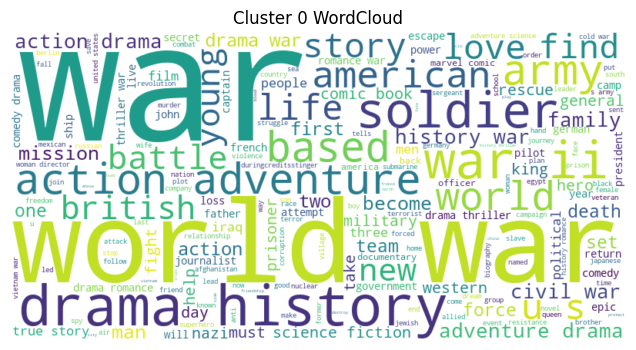

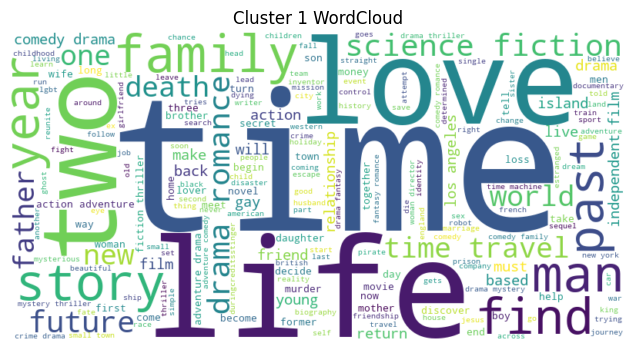

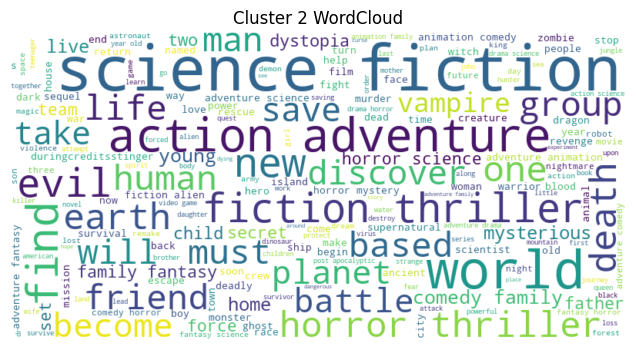

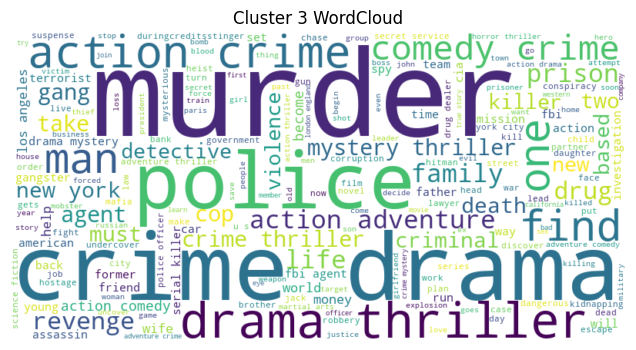

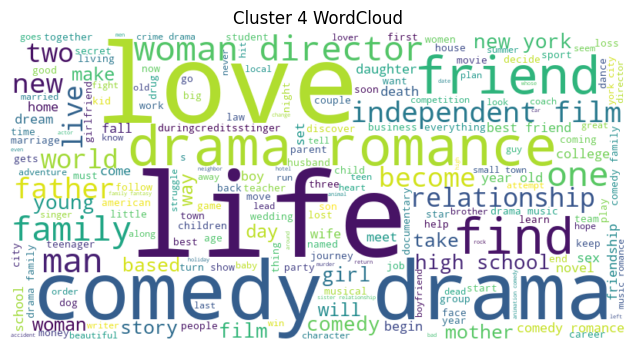

In [48]:
for cluster_id in range(5):
    cluster_df = predictions.filter(col("prediction") == cluster_id)
    text = " ".join(cluster_df.select("Document").rdd.flatMap(lambda x: x).collect())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} WordCloud")
    plt.show()


| Cluster             | Tóm tắt chủ đề và nội dung                                                                                                                                                                                                                                                                     | Count |
|---------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------|
| **Cluster 0**       | Tập trung vào các chủ đề liên quan đến chiến tranh, kịch lịch sử. Wordcloud nổi bật các chủ đề như chiến tranh, lịch sử, binh sĩ và các trải nghiệm của con người trong chiến tranh như sự sống, cái chết và anh hùng.                                                                           | 379   |
| **Cluster 1**       | Tập trung vào các chủ đề liên quan đến thời gian, cuộc đời, tình yêu và gia đình. Thể loại và các yếu tố cốt truyện chủ yếu  là “khoa học viễn tưởng”, “chính kịch”, “lãng mạn”, liên quan đến du hành thời gian, quá khứ....                                                             | 381   |
| **Cluster 2**       | Có các chủ đề tưởng tượng, không có thực; các sự việc hiện tượng siêu nhiên, sinh vật không thật, yếu tố cốt truyện chủ yếu nổi bật các thể loại như "khoa học viễn tưởng", "hành động", "phiêu lưu", hành tinh, "kinh dị"..., nhiều phim hành động phiêu lưu...                                                                       | 973   |
| **Cluster 3**       | Tập trung vào các chủ đề liên quan đến thể loại phim tội phạm và kinh dị. Chủ đề nổi bật: Các từ như “giết người”, “tội ác”, “kịch tính” và “cảnh sát” là những từ nổi bật, cho thấy sự tập trung vào các vở kịch tội phạm và tình tiết liên quan đến việc thực thi pháp luật. Các từ “kinh dị”, “hành động”, “thám tử” và “trả thù” cho thấy rằng các phim trong cụm này có thể bao gồm các yếu tố kinh dị, hồi hộp và đậm chất hành động. | 912   |
| **Cluster 4**       | Đại diện cho các chủ đề và yếu tố thường thấy trong các bộ phim lãng mạn, hài hước. Những từ nổi bật nhất, “tình yêu”, “cuộc sống”, “hài kịch”, “kịch tính” và “lãng mạn”, gợi ý những câu chuyện tập trung vào các mối quan hệ tình cảm, hành trình cảm xúc và sự hài hước trong các tình huống hàng ngày. Các thuật ngữ như “trường trung học”, “cha”, “mẹ” và “bạn bè” chỉ ra các bối cảnh và mối quan hệ chung thúc đẩy cốt truyện trong các thể loại này. Bối cảnh điện ảnh đô thị: “phụ nữ”, “đàn ông” và “New York”.  | 1739  |


In [49]:
predictions.toPandas().to_csv('predictions.csv')